In [1]:
%matplotlib inline
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.datasets import ad_hoc_data, breast_cancer

from classifiers.quantum.qasvm import NormQSVM, PseudoNormQSVM
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from classifiers.visualization import Plot_SVM

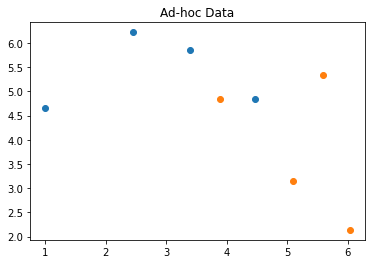

In [4]:
dim = 2
X, y, Xt, yt, total = ad_hoc_data(
    training_size=2**4,
    test_size=2**4,
    n=dim,
    plot_data=True,
    one_hot=False,
    gap=0.3,
    include_sample_total=True
)

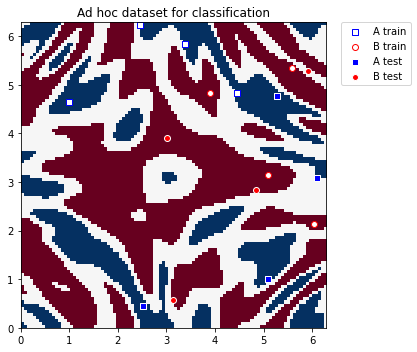

In [5]:
plt.figure(figsize=(6, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(total).T, interpolation='nearest',origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(X[np.where(y[:] == 0), 0], X[np.where(y[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='b', label="A train")
plt.scatter(X[np.where(y[:] == 1), 0], X[np.where(y[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r', label="B train")
plt.scatter(Xt[np.where(yt[:] == 0), 0], Xt[np.where(yt[:] == 0), 1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(Xt[np.where(yt[:] == 1), 0], Xt[np.where(yt[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")

plt.tight_layout()
plt.savefig('./tmp/fig')

In [6]:
feature_map =  ZZFeatureMap(feature_dimension=dim, reps=2, entanglement='linear')
#var_form = RealAmplitudes(3, entanglement='linear', reps=2)
backend = QuantumInstance(AerSimulator(), shots=2**13, seed_simulator=None)
nqsvm = NormQSVM(X, y, quantum_instance=backend, lamda=1, feature_map=feature_map, var_form=var_form)
storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**10, blocking=True, callback=storage, last_avg=16)

In [7]:
from tqdm.notebook import tqdm
last_avg = 16
epochs = 2**3
for epoch in tqdm(range(epochs)):
    optimizer.step(nqsvm.cost_fn, nqsvm.parameters)

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
nqsvm.parameters = storage.last_avg(last_avg, True)

(0.0, 0.3)

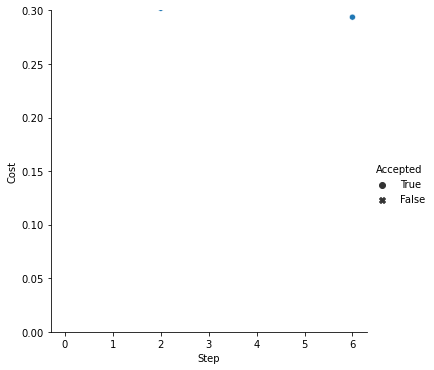

In [9]:
storage.plot()
plt.ylim([0, 0.3])

In [10]:
storage.num_accepted()

7

In [11]:
nqsvm.accuracy(Xt, yt)

0.5

In [12]:
nqsvm.save('./tmp/nqsvm')
Xtot = np.concatenate([X, Xt])
ytot = np.concatenate([y, yt])
np.save('./tmp/Xtot.npy', Xtot)
np.save('./tmp/ytot.npy', ytot)
# esty = nqsvm.predict(Xtot)
raise Exception

Exception: 

# Run 'analy_nqsvm.py' fisrt

<ipython-input-13-6ed7f72132bf>:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(Xtot[np.where(esty!=ytot), 0], Xtot[np.where(esty!=ytot), 1],


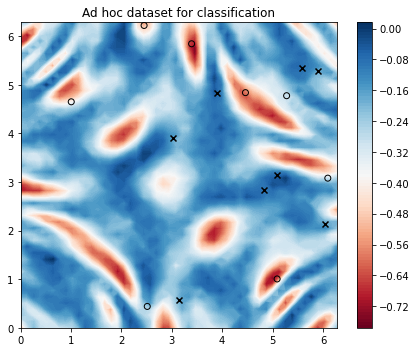

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dill

with open('./tmp/nqsvm', 'rb') as f:
    nqsvm = dill.load(f)
Xtot = np.load('./tmp/Xtot.npy')
ytot = np.load('./tmp/ytot.npy')
XX, YY, ZZ = np.load('./tmp/XYZ.npy')
esty = np.load('./tmp/esty.npy')

plt.figure(figsize=(6, 5))
plt.contourf(XX, YY, ZZ, levels=100, cmap='RdBu')
plt.colorbar()
# plt.scatter(X[np.where(y[:] == 0), 0], X[np.where(y[:] == 0), 1],
            # marker='s', facecolors='w', edgecolors='b', label="A train")
# plt.scatter(X[np.where(y[:] == 1), 0], X[np.where(y[:] == 1), 1],
            # marker='o', facecolors='w', edgecolors='r', label="B train")
# plt.scatter(Xt[np.where(yt[:] == 0), 0], Xt[np.where(yt[:] == 0), 1],
            # marker='s', facecolors='b', edgecolors='w', label="A test")
# plt.scatter(Xt[np.where(yt[:] == 1), 0], Xt[np.where(yt[:] == 1), 1],
            # marker='o', facecolors='r', edgecolors='w', label="B test")
plt.scatter(Xtot[np.where(esty==ytot), 0], Xtot[np.where(esty==ytot), 1],
            marker='o', facecolors='none', edgecolors='k', label="Correct")
plt.scatter(Xtot[np.where(esty!=ytot), 0], Xtot[np.where(esty!=ytot), 1],
            marker='x', facecolors='k', edgecolors='k', label="Wrong")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")
plt.tight_layout()
plt.savefig('./tmp/result.png')

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table





/home/quic/anaconda3/envs/qiskit29/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [15]:
sum(esty==ytot)/len(esty)


0.5